<a href="https://colab.research.google.com/github/plaban1981/Pytorch_lightning/blob/main/Pneumonia_Classification_Challenge_by_Segmind_pytorch_lightning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline
import os

## Download Images

In [2]:
from google_drive_downloader import GoogleDriveDownloader as gdd

gdd.download_file_from_google_drive(file_id='1d_93d9oFNRBK9Vg6BRxs9wvRbKtNTylY',
                                    dest_path='content/pneumonia_dataset.zip',
                                    unzip=True)

Unzipping...Done.


## Import ktrain

In [115]:
%%capture 
!pip install pytorch-lightning

##Image Classification

In [119]:
import pytorch_lightning as pl
#
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split # For splitting the data into train and validation set
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import f1_score, confusion_matrix
#
import seaborn as sns
import matplotlib.pyplot as plt
import os
import shutil
import glob
#
import torch
from torchvision import transforms
import torch.optim as optim
import torch.nn.functional as F
from torchvision import models
from torch.utils.data import DataLoader,Dataset
#
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
#
from PIL import Image
#
import warnings
warnings.filterwarnings('ignore')

In [147]:
image_folder = os.listdir("/content/content/pneumonia_dataset/train")
filename = []
label = []
for folder in image_folder:
  for image_name in os.listdir(os.path.join("/content/content/pneumonia_dataset/train",folder)):
    filename.append("train/"+folder+"/"+image_name)
    label.append(folder)

##Train data

In [148]:
train_df = pd.DataFrame({'filename':filename,'label':label})
train_df.head()

,filename,label
0,train/normal/CXR_train_2342.png,normal
1,train/normal/CXR_train_1312.png,normal
2,train/normal/CXR_train_1577.png,normal
3,train/normal/CXR_train_1802.png,normal
4,train/normal/CXR_train_1330.png,normal


In [149]:
train_df.to_csv("/content/content/pneumonia_dataset/train.csv",index=False)

## Viusalize Labels

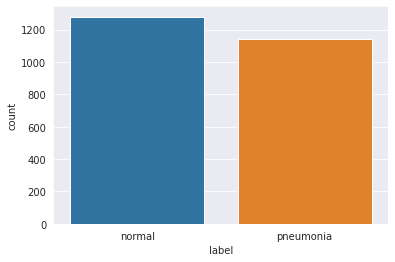

In [8]:
sns.set_style('darkgrid')
sns.countplot(x='label',data=train_df)

## Train Test Split Data

In [54]:
train,test= train_test_split(train_df,test_size=0.2,random_state=42,stratify=train_df["label"])

In [55]:
train.shape,test.shape

((1940, 2), (485, 2))

In [56]:
#train.to_csv("/content/content/pneumonia_dataset/train.csv",index=False)
test.to_csv("/content/content/pneumonia_dataset/valid.csv",index=False)

## Prepare Dataset

In [144]:
class PneumoniaDataset(Dataset):
  def __init__(self,root_dir,transform=None,stage=None):
    self.root_dir = root_dir
    if stage == 'test':
      out_file_path = os.path.join(root_dir,"test.csv")
      csv_output = pd.read_csv(out_file_path)
      self.images_dir = os.path.join(root_dir,"test")
    else:
      out_file_path = os.path.join(root_dir,"train.csv")
      csv_output = pd.read_csv(out_file_path)
      self.images_dir = os.path.join(root_dir,"train")
      self.image_urls = csv_output["filename"].values
      self.labels = np.array(csv_output["label"])
      self.transform = transform
  def __len__(self):
    return len(self.image_urls)
  def __getitem__(self,idx):
    image_path = os.path.join(self.root_dir,self.image_urls[idx])
    image = Image.open(image_path)
    if self.transform :
      image = self.transform(image)
    #get label
    label = self.labels[idx]
    return image,label

In [150]:
ds = PneumoniaDataset("/content/content/pneumonia_dataset")

In [152]:
ds.__getitem__(1)

(<PIL.PngImagePlugin.PngImageFile image mode=L size=1024x1024 at 0x7FBCAE68BB90>,
 'normal')